In [1]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
import scipy as sp
from matplotlib import pyplot as plt
import time

In [2]:
import pickle
from scipy.io import savemat
import cupy as cp


In [3]:
rootfolder = '/kaggle/input/mmmipdataset/'


Useful function for plot the dictionary

In [4]:
def get_dictionary_img(D):
    M, N = D.shape
    p = int(round(np.sqrt(M)))
    nnn = int(np.ceil(np.sqrt(N)))
    bound = 2
    img = np.ones((nnn*p+bound*(nnn-1), nnn*p+bound*(nnn-1)))
    for i in range(N):
        m = np.mod(i, nnn)
        n = int((i-m)/nnn)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Set all the paramters for the anomaly detection

In [5]:
# patch size (tha patch is square)
p = 15

# number of patches in the training set for dictionary learning
npatch_dictionary = 10000

# number of patches to estimate the confidence region
npatch_region = 1000

# paramters for the dictionary learning using the KSVD
niter_dl = 10
natom = int(np.round(p**2*1.5))
L = 4

# regularization parameters for the l1 sparse coding
lmbda = 0.18

Construct the training and validation sets
------------------------------------------

In [6]:
# load the training image and rescale it in [0,1]
img = imread(f'{rootfolder}img_normal.png') / 255

# extract random patches from the image and store them in a matrices S, V
S = np.zeros((p**2, npatch_dictionary))
for i in range(npatch_dictionary):
    x = np.random.randint(0, img.shape[0] - p)
    y = np.random.randint(0, img.shape[1] - p)
    S[:, i] = img[x:x+p, y:y+p].reshape(-1, order='F')
V = S.copy()

Dictionary Learning
-------------------
Perform preprocessing on the patches in $S$

In [7]:
# PREPROCESSING: exclude black patches from S
v = np.median(S, axis=0)
S = S[:,v > 0.06]

In [8]:
# PREPROCESSING: remove the mean from each patch
S = S - np.mean(S, axis=0)


Perform dictionary learning via KSVD or MOD

In [9]:
def SoftThresholding(x, l):
    return np.sign(x) * np.maximum(np.abs(x) - l, 0)
def Fista(s, A, lmbda, x=None):
    if x is None:
        x = np.zeros(A.shape[1])+1
    x_past = x
    max_iter = 1e3
    tol_dist_x = 1e-6
    # set the optimal value for alpha
    alpha = 1 / np.max(np.linalg.eigvals(A.T@A).real)
    # initialize y
    y = x
    # initialize gamma
    gamma = 1
    #grad_norm = 1e10
    distanceX = 1e10
    cnt = 0
    while cnt < max_iter and distanceX > tol_dist_x:
        # compute the argument of the proximal operator
        # perform soft thresholding of x
        x = SoftThresholding(y - alpha * (A.T @ (A @ y) - A.T @ s), alpha*lmbda)
        # update gamma
        gamma_new = (1 + np.sqrt(1 + 4 * gamma ** 2)) / 2
        # update y
        y = x + (gamma - 1) / gamma_new * (x - x_past)
        gamma = gamma_new
        # compute the stopping criteria
        distanceX = np.linalg.norm(x - x_past)
        x_past = x
        cnt += 1
    return x

def Mod(S, lmbda):
    max_iter = niter_dl
    N = natom
    D = np.random.randn(S.shape[0], N)
    D = D / np.linalg.norm(D, axis=0)

    X = np.zeros((N, S.shape[1]))
    iter = 0
    error = 1e10
    while iter < max_iter and error > 1e-3:

        # perform the sparse coding for all the patches in S
        for n in range(S.shape[1]):
            s = S[:, n]
            x = Fista(s, D, lmbda)
            X[:, n] = x

        # MOD update
        D = S @ X.T @ np.linalg.inv(X @ X.T)
        #D = D - gamma * (D @ X - S) @ X.T
        # normalize the column
        D = D / np.linalg.norm(D, axis=0)
        error = np.linalg.norm(S - D @ X)
        iter += 1
    return D


In [11]:
#D = Mod(S, lmbda)

# or load a precomputed dictionary
D = loadmat(f'{rootfolder}dict_anom_det.mat')['D']

# my learned dictionary
#D = loadmat(f'{rootfolder}dictionary17.mat')['D']

In [12]:
# f_path = '../data/dictionary17.mat'
# savemat(f_path, {"D": D})

Show the learned dictionary

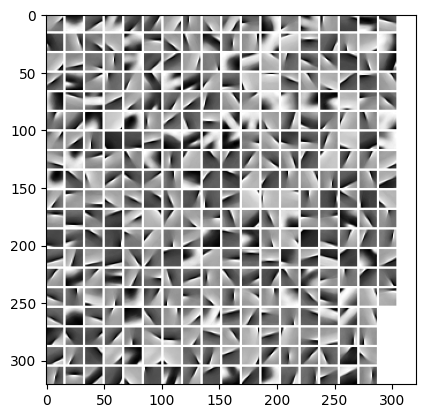

In [13]:
img_dict = get_dictionary_img(D)
plt.imshow(img_dict, cmap='gray')
plt.show()

## Confidence region estimation / density estimation

In [14]:
# PREPROCESSING: exclude black patches
v = np.median(V, axis=0)
V = V[:,v > 0.06]

In [15]:
# PREPROCESSING: remove the mean from each patch
for i in range(V.shape[1]):
    V[:, i] = V[:, i] - np.mean(V[:, i])

In [16]:
# sparse coding of each patch in V
X = np.zeros((natom, npatch_region))
for i in range(npatch_region):
    X[:, i] = Fista(V[:, i], D, lmbda)
    



In [17]:
# computing the anomaly indicators (l1 norm, reconstruction error) for each
# patch in V

A = np.zeros((2, npatch_region))     # each column contains the values of the anomaly_scores for a patch

for i in range(npatch_region):
    A[:,i] = np.array([np.linalg.norm(V[:,i] - D @ X[:,i]), np.linalg.norm(X[:,i], 1)])

# Estimation of mean and covariance
mu = np.mean(A, axis=1)
Sigma = np.cov(A)
SigmaInv = np.linalg.inv(Sigma)


In [18]:
# estimation of the threshold that gives the desired false positive rate
# using the patches in V

FPR_target = 0.1

# compute the mahalanobis distance for each indicator vector in A
mahal_dist = np.zeros(V.shape[1])
for i in range(A.shape[1]):
    #mahal_dist[i] = (A[:,i] - mu).T @ SigmaInv @ (A[:,i] - mu)
    mahal_dist[i] = sp.spatial.distance.mahalanobis(A[:,i], mu, SigmaInv)**2

# set the threshold
threshold = np.quantile([mahal_dist[i] for i in range(A.shape[1])] , 1-FPR_target)



## Test phase

In [19]:
# load the test image
img_test = imread(f'{rootfolder}img_anom.png') / 255

imsz = img_test.shape

STEP = 7
# initialize the estimated image
heatmap = np.zeros_like(img)

# initialize the weight matrix
weights = np.zeros_like(img)

In [20]:

for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # extrach the patch with the top left corner at pixel (ii, jj)
        s = img_test[i:i+p, j:j+p].reshape(-1)

        # if the median of s is to small set the anomaly score to 0:
        if np.median(s) <= 0.06:
            score = 0
        else:
            # subratct the mean to the patch
            s = s - np.mean(s)

            # perform the sparse coding
            x = Fista(s, D, lmbda)

            # compute the anomaly indicators vector
            a = np.array([np.linalg.norm(s - D @ x), np.sum(np.abs(x))])

            # compute the anomaly score
            score = sp.spatial.distance.mahalanobis(a, mu, SigmaInv)**2

        # update the heatmap
        heatmap[i:i+p, j:j+p] = heatmap[i:i+p, j:j+p] + score

        # update the weight matrix
        weights[i:i+p, j:j+p] = weights[i:i+p, j:j+p] + 1


In [22]:
# normalize the heatmap
#heatmap = heatmap / weights
heatmap[:-3,:-4] = heatmap[:-3,:-4] / weights[:-3,:-4]

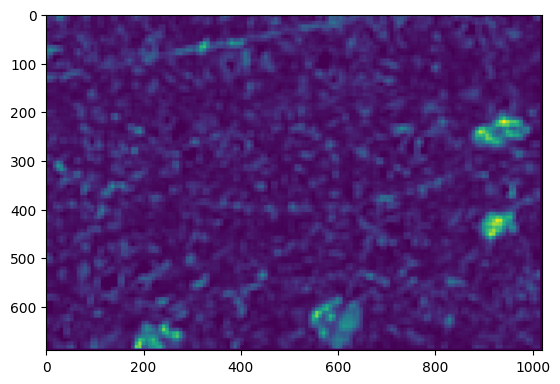

In [23]:
# plot the heatmap
plt.imshow(heatmap)

In [24]:
# build the detection mask, that has the same size of the test image
# each pixel in the mask has value 1 if the corresponding patch has been
# detected as anomalous, otherwise it has value 0
mask = np.zeros_like(img_test)
mask[heatmap > threshold] = 1


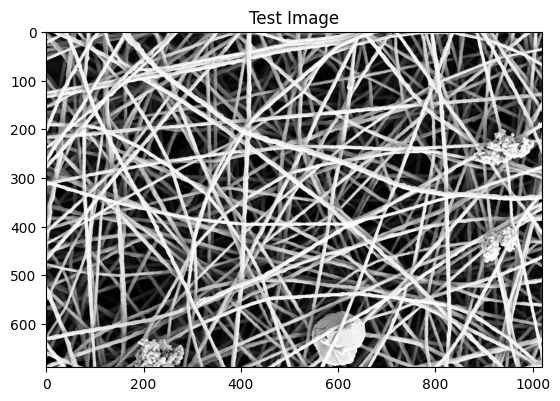

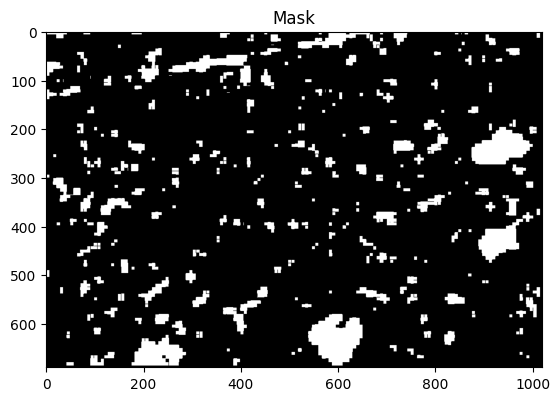

In [25]:
## show the results
plt.figure(3), plt.imshow(img_test, cmap='gray'), plt.title('Test Image')
plt.figure(4), plt.imshow(mask, cmap='gray'), plt.title('Mask')
plt.show()

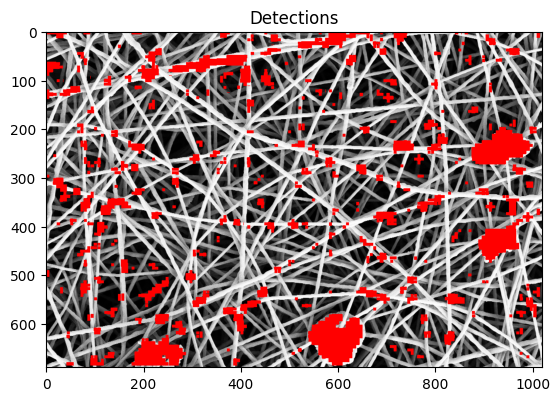

In [26]:
# combine the mask and the test image
img_color = np.zeros([img_test.shape[0], img_test.shape[1], 3])
img_temp = img_test.copy()
img_temp[mask > 0] = 1
img_color[:,:,0] = img_temp
img_temp = img_test.copy()
img_temp[mask > 0] = 0
img_color[:,:,1] = img_temp
img_temp = img_test.copy()
img_temp[mask > 0] = 0
img_color[:,:,2] = img_temp

plt.figure(5), plt.imshow(img_color), plt.title('Detections')
plt.show()